# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [4]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        # <your code>
        return 1 / (1 + np.exp(-X@weights))
        
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        # <your code>
        loss = np.mean(np.log(1+np.exp(-np.dot(x, weights)*y))) + 1/(2*self.C)*np.amin((np.linalg.norm(weights))**2)
        return loss
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        losses = []
        for i in range(self.max_iter):
            loss = self.get_loss(X_ext, self.weights_, y)
            losses.append(loss)
            delta = X_ext.T@(y*(1.- 1./(1+np.exp(np.dot(-X_ext, self.weights_)*y))))/len(y)-(1/self.C)*self.weights_
            self.weights_ -= self.eta * delta * (-1.)
            if np.linalg.norm(delta) < self.tol:
                break
        return losses
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        return np.where(self.predict_proba(X) >= 0.5, 1, -1)

In [5]:
from sklearn import datasets
from sklearn import metrics

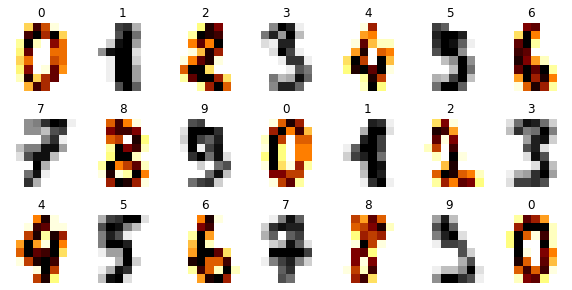

In [6]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [7]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [8]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [9]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [10]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [11]:
lr_clf.fit(X_train, y_train)

[0.6931471805599453]

In [12]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [13]:
model = CustomLogisticRegression()

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


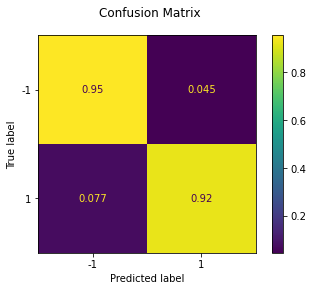

In [14]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [15]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [16]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

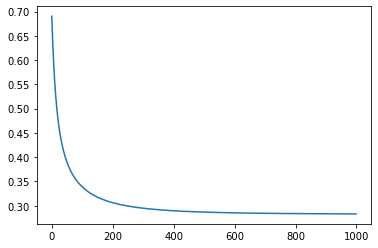

In [17]:
## your code
loss_history = model.fit(X_train, y_train)
plt.plot(loss_history);

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

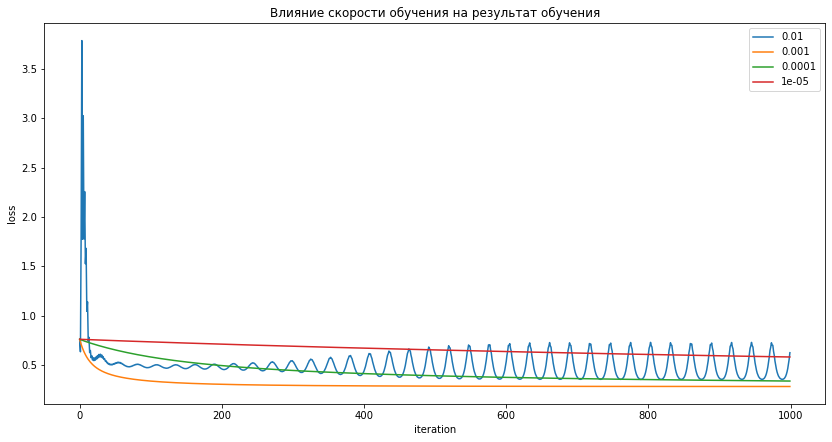

In [18]:
## your code
model_01 = CustomLogisticRegression(eta=0.01)
loss_history_01 = model_01.fit(X_train, y_train)
model_001 = CustomLogisticRegression(eta=0.001)
loss_history_001 = model_001.fit(X_train, y_train)
model_0001 = CustomLogisticRegression(eta=0.0001)
loss_history_0001 = model_0001.fit(X_train, y_train)
model_00001 = CustomLogisticRegression(eta=0.00001)
loss_history_00001 = model_00001.fit(X_train, y_train)

plt.figure(figsize=(14,7))
plt.plot(loss_history_01, label=0.01)
plt.plot(loss_history_001, label=0.001)
plt.plot(loss_history_0001, label=0.0001)
plt.plot(loss_history_00001, label=0.00001)
plt.legend()
plt.title('Влияние скорости обучения на результат обучения')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

При высокой скорости обучения (выше 0,001), модель быстро переобучается и показывает плохие результаты. При маленькой скорости обучения (меньше 0,001), модель очень долго обучается. Оптимальная скорость обучения 0,001.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


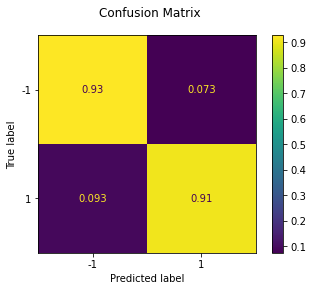

Качество модели при C=0.3


In [19]:
## your code
model_03 = CustomLogisticRegression(C=0.3)
model_03.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model_03, X_train, y_train, X_test, y_test)
print('Качество модели при C=0.3')

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


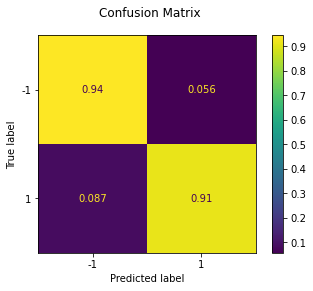

Качество модели при C=0.5


In [20]:
model_05 = CustomLogisticRegression(C=0.5)
model_05.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model_05, X_train, y_train, X_test, y_test)
print('Качество модели при C=0.5')

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


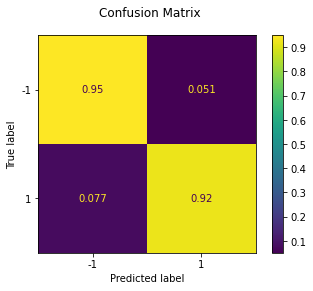

Качество модели при C=1


In [21]:
model_1 = CustomLogisticRegression(C=1)
model_1.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model_1, X_train, y_train, X_test, y_test)
print('Качество модели при C=1')

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


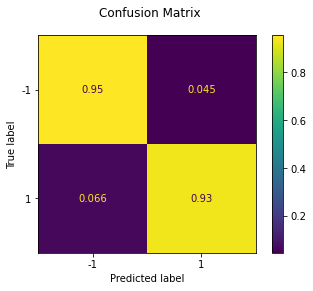

Качество модели при C=1.5


In [22]:
model_15 = CustomLogisticRegression(C=1.5)
model_15.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model_15, X_train, y_train, X_test, y_test)
print('Качество модели при C=1.5')

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


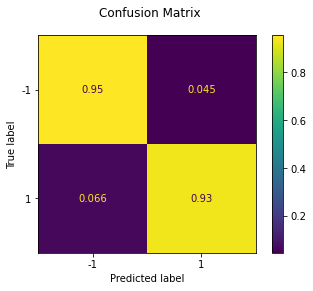

Качество модели при C=2


In [23]:
model_2 = CustomLogisticRegression(C=2)
model_2.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model_2, X_train, y_train, X_test, y_test)
print('Качество модели при C=2')

Ошибка при уменьшении C увеличивается. А при увеличении С улучшаются результаты правильных предсказаний модели. Значение параметра регуляризации выше 1,5 уже никак не увеличивает точность модели на наших данных.

**(0.5 points)** Compare zero initialization and random initialization. 

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


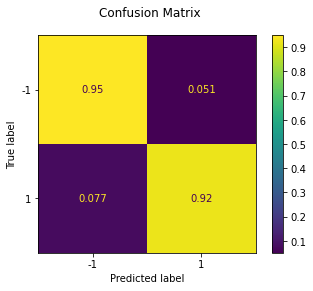

Качество модели при нулевой инициализации


In [24]:
## your code
model_false_zero_init = CustomLogisticRegression()
model_false_zero_init.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model_false_zero_init, X_train, y_train, X_test, y_test)
print('Качество модели при нулевой инициализации')

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


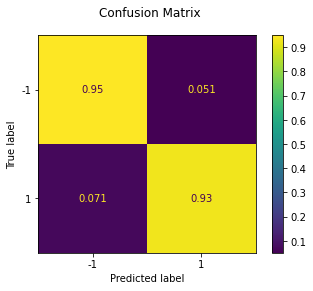

Качество модели при случайной инициализации


In [25]:
model_true_zero_init = CustomLogisticRegression(zero_init=True)
model_true_zero_init.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model_true_zero_init, X_train, y_train, X_test, y_test)
print('Качество модели при случайной инициализации')

При случайной инициализации первоначальных весов модели в нашем случае чуть-чуть улучшило результаты предсказания модели.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [26]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        # <your code>
        P = np.add.outer(np.sum(X**2, axis=1), np.sum(Y**2, axis=1))
        N = np.dot(X, Y.T)
        dist = np.sqrt(P - 2*N)
        return dist
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        # <your code>
        weights_total = []
        df_weig = pd.DataFrame(weights)
        df_weig['metrics'] = y
        #print(df_weig)
        att = df_weig.groupby('metrics').sum().to_dict()
        weights_total = []
        for i in self.classes_:
            try:
                weights_total.append(att[0][i])
            except: weights_total.append(0)
        return weights_total
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            p_small_dist = np.sort(P, axis=1)[:,:self.n_neighbors]
            y_small_dist = self.y[P.argsort(axis=1)[:,:self.n_neighbors]]
            weights_of_points = np.ones(p_small_dist.shape)
            if self.weights == 'distance':
                weights_of_points = 1 / (p_small_dist + self.eps)
            weights_i = []
            for i in range(weights_of_points.shape[0]):
                weights_i.append(self.get_class_weights(y_small_dist[i], weights_of_points[i]))
            y_prob = np.array(weights_i) / np.sum(weights_i, axis=1)[:, None]    
            # <your code>
            return y_prob
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        res = self.predict_proba(X)
        return np.argmax(res, axis=1)

In [27]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [28]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [29]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

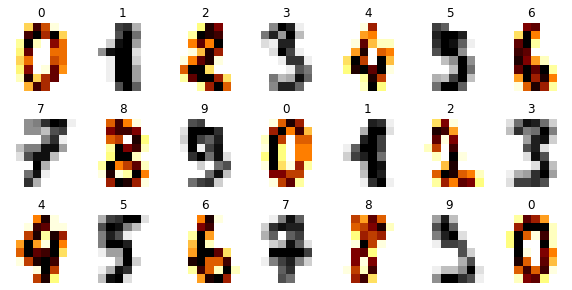

In [30]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [31]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [32]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


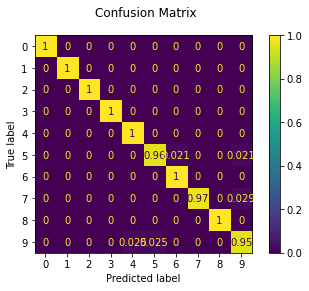

In [33]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [34]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

Модель путает цифру 5 с цифрами 6 и 9 - если к цифре 5 внизу добавить палочку - получится цифра 6, если сверху нарисовать - получится цифра 9. Цифру 7 путает с цифрой 9, у цифры семь верхняя часть размытая и она очень похожа на цифру 9. А цифру 9 путает с цифрами 4 и 5, потому что цифра 5 легко превращается в цифру 9, а цифра 4 очень похожа на цифру 9 с маленьким хвостом.

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


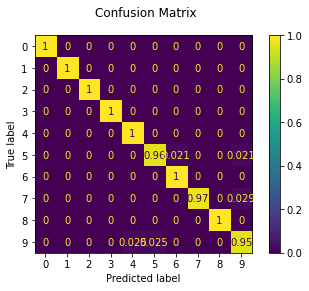

Предсказания модели по 5 соседям: 0.9861111111111112


In [35]:
## your code
model = CustomKNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print('Предсказания модели по 5 соседям:', test_acc)

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


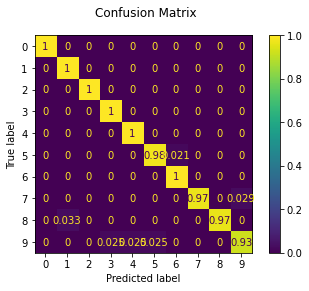

Предсказания модели по 3 соседям: 0.9833333333333333


In [36]:
model = CustomKNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print('Предсказания модели по 3 соседям:', test_acc)

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


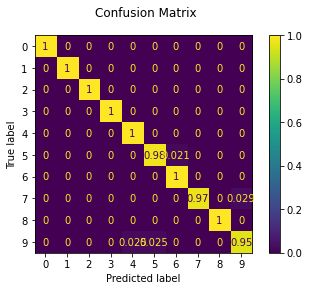

Предсказания модели по 7 соседям: 0.9888888888888889


In [37]:
model = CustomKNeighborsClassifier(n_neighbors=7)
model.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print('Предсказания модели по 7 соседям:', test_acc)

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


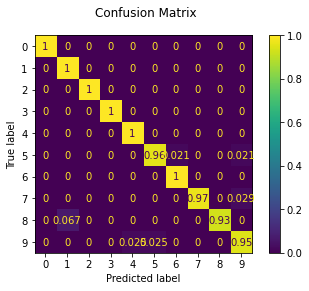

Предсказания модели по 9 соседям: 0.9805555555555555


In [38]:
model = CustomKNeighborsClassifier(n_neighbors=9)
model.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print('Предсказания модели по 9 соседям:', test_acc)

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


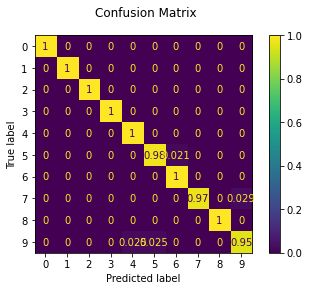

Предсказания модели по 6 соседям: 0.9888888888888889


In [39]:
model = CustomKNeighborsClassifier(n_neighbors=6)
model.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print('Предсказания модели по 6 соседям:', test_acc)

Модель улучшила результаты при параметре n_neighbors равном 6 и 7. Модель перестала путать цифру 5 с цифрой 9. Дальнейшее увеличение числа соседей ухудшили точность модели, также как и уменьшение числа соседей.

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


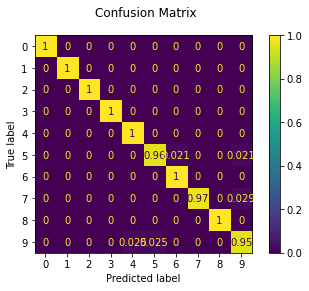

Предсказания модели по однородным весам для всех соседей: 0.9861111111111112


In [40]:
## your code
model = CustomKNeighborsClassifier(weights='uniform')
model.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print('Предсказания модели по однородным весам для всех соседей:', test_acc)

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


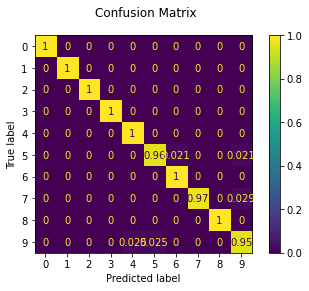

Предсказания модели по взвешенным весам для всех соседей: 0.9861111111111112


In [41]:
model = CustomKNeighborsClassifier(weights='distance')
model.fit(X_train, y_train)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print('Предсказания модели по взвешенным весам для всех соседей:', test_acc)

Для нашей модели не имеет разницы весовая функция, используемая в прогнозировании. Имеет смысл использовать взвешенные веса для соседей при предсказании большого числа классов (более 3), когда могут возникнуть неоднозначные ситуации при одинаковом количестве соседей для нескольких классов.

In [42]:
X_train[0]

array([ 0.,  0.,  3., 14.,  1.,  0.,  0.,  0.,  0.,  0., 12., 12.,  0.,
        0.,  0.,  0.,  0.,  3., 16.,  6.,  0.,  0.,  0.,  0.,  0.,  5.,
       16.,  2.,  0.,  0.,  0.,  0.,  0.,  6., 16.,  2.,  5.,  2.,  0.,
        0.,  0.,  4., 16.,  2., 12., 15.,  2.,  0.,  0.,  1., 14., 13.,
        2., 13., 11.,  0.,  0.,  0.,  3., 11., 16., 13.,  4.,  0.])

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

Для целочисленных значений используются такие функции как 'hamming', 'canberra', 'braycurtis'. Возможно с такими функциями для измерения дистанции получится увеличить метрику предсказания.

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [43]:
PATH = "./data/"

In [44]:
data = pd.read_csv('train.csv').set_index('PassengerId')

In [45]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

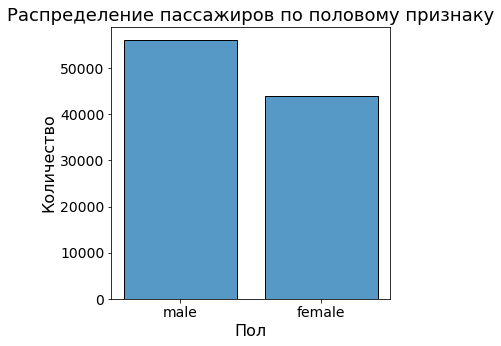

In [46]:
fig = plt.figure(figsize=(5, 5))
plt.title('Распределение пассажиров по половому признаку', fontdict={'fontsize':18})
sns.histplot(data=data, x=data['Sex'], multiple="dodge", shrink=0.8, bins=2)
plt.ylabel('Количество', size=16)
plt.xlabel('Пол', size=16)
plt.yticks(size=14)
plt.xticks(size=14)
plt.show()

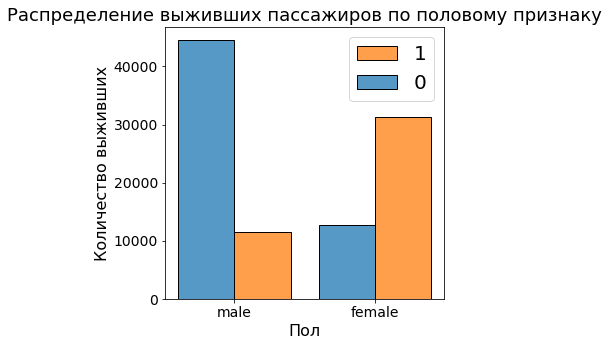

In [47]:
fig = plt.figure(figsize=(5, 5))
plt.title('Распределение выживших пассажиров по половому признаку', fontdict={'fontsize':18})
sns.histplot(data=data, x=data['Sex'], hue=data['Survived'], multiple="dodge", shrink=0.8, bins=4)
plt.legend(data['Survived'].unique(), fontsize=20)
plt.ylabel('Количество выживших', size=16)
plt.xlabel('Пол', size=16)
plt.yticks(size=14)
plt.xticks(size=14)
plt.show()

В датасете пассажиров-мужчин больше, чем пассажиров-женщин. Мужчин около 57 тыс., женщин около 43 тыс. Причем выжило женщин гораздо больше мужчин. Женщин спаслось около 30 тыс., а мужчин около 10 тыс.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

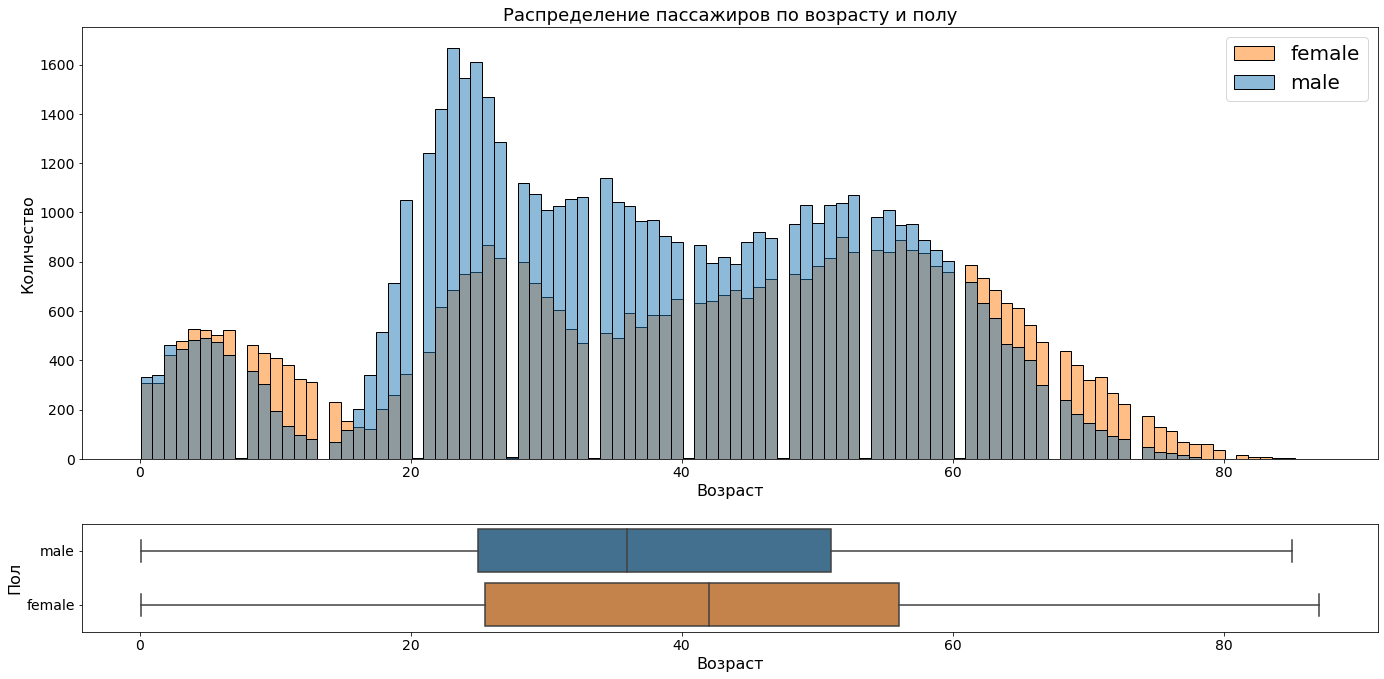

In [48]:
## your code
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_axes([0, 0.4, 1, 1])
plt.title('Распределение пассажиров по возрасту и полу', fontdict={'fontsize':18})
sns.histplot(data=data, x=data['Age'], hue=data['Sex'], bins=100)
plt.legend(['female', 'male'], fontsize=20)
plt.ylabel('Количество', size=16)
plt.xlabel('Возраст', size=16)
plt.yticks(size=14)
plt.xticks(size=14)

ax2 = fig.add_axes([0, 0, 1, 0.25])
sns.boxplot(y='Sex', x='Age', data=data, orient='h', saturation=0.5)
plt.ylabel('Пол', size=16)
plt.xlabel('Возраст', size=16)
plt.yticks(size=14)
plt.xticks(size=14)
plt.show()

На основе данных графиков можно сделать некоторые выводы:

 - мужчин на корабле было больше, чем женщин
 - больше всего мужчин в возрасте 20-25 лет
 - больше всего женщин в возрасте 25 лет и 50-53 года
 - количество женщин преобладают в категории возраса 60+, а также в диапазоне от 3-х до 16 лет
 - количество мужчин преобладает в возрасте от 16 до 60 лет, а также незначительно в возрасте до 3-х лет
 - основная масса мужчин находится в диапазоне 24-50 лет
 - основная масса женщин находится в диапазоне 25-55 лет

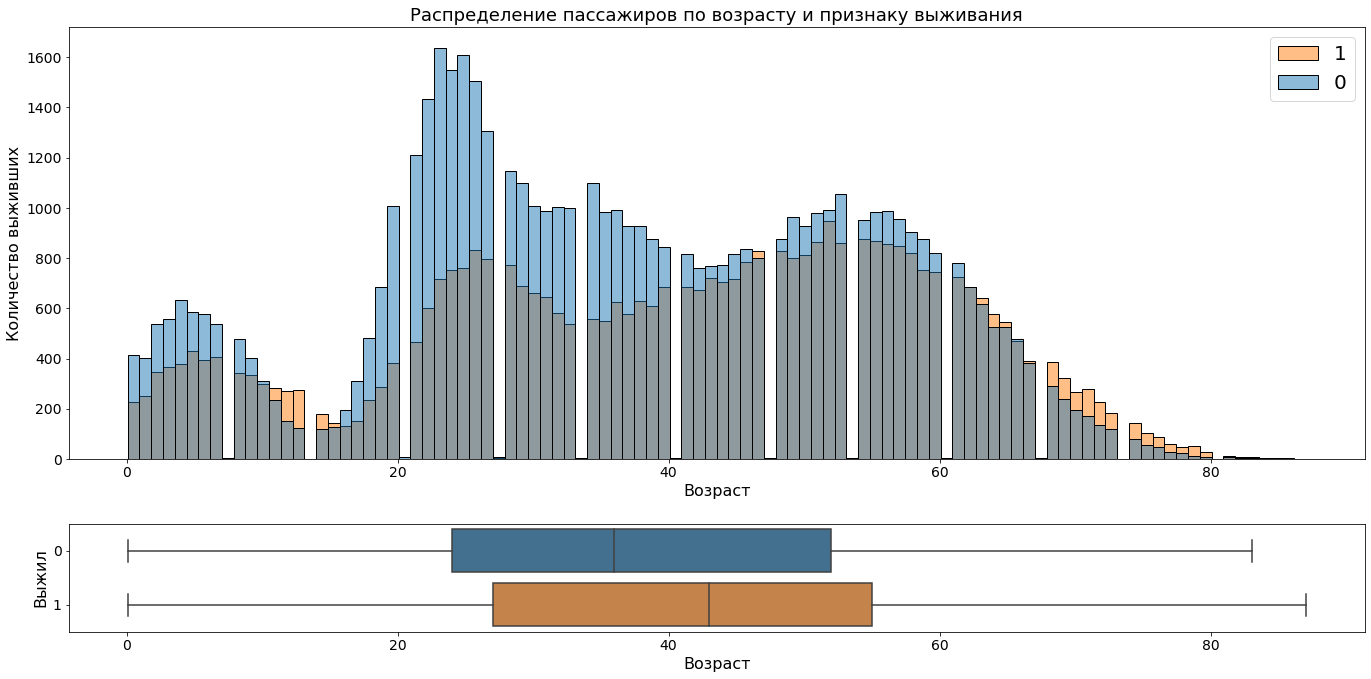

In [49]:
# посмотрим на возраст пассажиров в разрезе количества выживших

fig = plt.figure(figsize=(18, 6))

ax1 = fig.add_axes([0, 0.4, 1, 1])
plt.title('Распределение пассажиров по возрасту и признаку выживания', fontdict={'fontsize':18})
sns.histplot(data=data, x=data['Age'], hue=data['Survived'], bins=100)
plt.legend(data['Survived'].unique(), fontsize=20)
plt.ylabel('Количество выживших', size=16)
plt.xlabel('Возраст', size=16)
plt.yticks(size=14)
plt.xticks(size=14)

ax2 = fig.add_axes([0, 0, 1, 0.25])
sns.boxplot(y='Survived', x='Age', data=data, orient='h', saturation=0.5)
plt.ylabel('Выжил', size=16)
plt.xlabel('Возраст', size=16)
plt.yticks(size=14)
plt.xticks(size=14)
plt.show()

По данному графику видно, что соотношение выживших и утонувших пассажиров от 40 лет примерно одинаковое. Пассажиры в возрасте покупали билеты классом повыше. У классов повыше расстояние до шлюпочной палубы меньше, чем у пассажиров 3-го класса.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

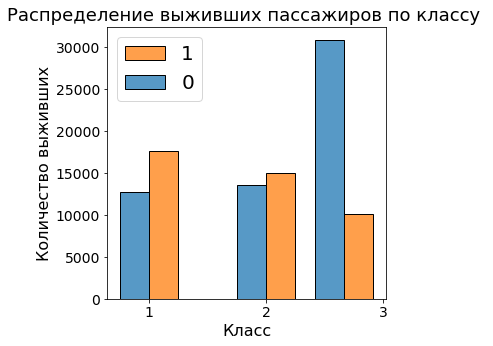

In [50]:
## your code
fig = plt.figure(figsize=(5, 5))
plt.title('Распределение выживших пассажиров по классу ', fontdict={'fontsize':18})
sns.histplot(data=data, x=data['Pclass'], hue=data['Survived'], multiple="dodge", shrink=1.5, bins=6)
plt.legend(data['Survived'].unique(), fontsize=20)
plt.ylabel('Количество выживших', size=16)
plt.xlabel('Класс', size=16)
plt.xticks(range(1, 4), ['1', '2', '3'])
plt.yticks(size=14)
plt.xticks(size=14)
plt.show()

Больше спаслось пассажиров первого и второго класса. Вероятно потому, что расстояние от кают 3 класса до палубы больше.

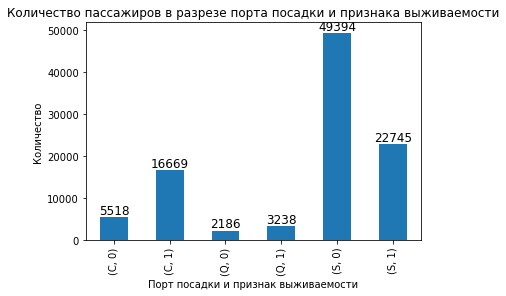

In [51]:
# посмотрим на признак выживаемости от порта посадки
data.groupby(['Embarked', 'Survived'])['Embarked'].count().plot(kind='bar',
                                            title='Количество пассажиров в разрезе порта посадки и признака выживаемости',
                                            xlabel='Порт посадки и признак выживаемости', ylabel='Количество')
for i, val in enumerate(data.groupby(['Embarked', 'Survived'])['Embarked'].count().values):
    plt.text(i, val, int(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'size':12})

Больше всего пассажиров село в порту Southampton - около 73%. Среди них выжило около 30%. Около 20% пассажиров село в порту Cherbourg. Из этих пассажиров выжило 75%. Остальные сели в порту Queenstown - чуть больше 5%. Около 60% из них выжили. Самый безопасный порт - Cherbourg.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [52]:
## your code
for col in data.columns:
    print('{} - {} %'.format(col, np.mean(data[col].isnull()*100)))

Survived - 0.0 %
Pclass - 0.0 %
Name - 0.0 %
Sex - 0.0 %
Age - 3.292 %
SibSp - 0.0 %
Parch - 0.0 %
Ticket - 4.623 %
Fare - 0.134 %
Cabin - 67.866 %
Embarked - 0.25 %


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

В данных есть пропущенные значения. В признаке возраст пропущено более 3%. Заполним эти пропуски медианными значениями в зависимости от пола и класса. Также есть пропуски в билетах пассажиров - почти 5%. Есть несколько пропущенных значений в признаке стоимости билета. Эти пропуски заполним медианным значением. Почти 68% значений пропущены в признаке кабины. И несколько значений пропущено в признаке порта посадки. Заполним их модой.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [53]:
## your code
# заполним пропуски в признаке стоимости билета медианным значением
data['Fare'] = data['Fare'].fillna(data['Fare'].median())

# заполним пропуски в признаке возраста пассажиров медианными значениями в зависимости от пола и класса
median_f_1 = data['Age'][(data.Sex=='female') & (data.Pclass==1)].median()
median_f_2 = data['Age'][(data.Sex=='female') & (data.Pclass==2)].median()
median_f_3 = data['Age'][(data.Sex=='female') & (data.Pclass==3)].median()
median_m_1 = data['Age'][(data.Sex=='male') & (data.Pclass==1)].median()
median_m_2 = data['Age'][(data.Sex=='male') & (data.Pclass==2)].median()
median_m_3 = data['Age'][(data.Sex=='male') & (data.Pclass==3)].median()

data.loc[(data.Sex=='female') & (data.Pclass==1) & (pd.isna(data.Age)), 'Age'] = median_f_1
data.loc[(data.Sex=='female') & (data.Pclass==2) & (pd.isna(data.Age)), 'Age'] = median_f_2
data.loc[(data.Sex=='female') & (data.Pclass==3) & (pd.isna(data.Age)), 'Age'] = median_f_3
data.loc[(data.Sex=='male') & (data.Pclass==1) & (pd.isna(data.Age)), 'Age'] = median_m_1
data.loc[(data.Sex=='male') & (data.Pclass==2) & (pd.isna(data.Age)), 'Age'] = median_m_2
data.loc[(data.Sex=='male') & (data.Pclass==3) & (pd.isna(data.Age)), 'Age'] = median_m_3

# заполним пропуски в признаке порта посадки модой
data['Embarked'] = data['Embarked'].fillna('S')

In [54]:
data_1 = data.copy()
data_1

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,44.00,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,31.00,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
99995,1,2,"Bell, Adele",female,62.00,0,0,PC 15008,14.86,D17243,C
99996,0,2,"Brown, Herman",male,66.00,0,0,13273,11.15,NaN,S
99997,0,3,"Childress, Charles",male,37.00,0,0,NaN,9.95,NaN,S


In [55]:
# добавим признак наличия каюты
data_1['Сabin_availability'] = data_1['Cabin'].isna()
data_1['Сabin_availability'] = data_1['Сabin_availability'].replace({False:1, True:0})
data_1

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Сabin_availability
PassengerId,,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,44.00,2,0,209245,27.14,C12239,S,1
1,0,3,"Bryan, Drew",male,31.00,0,0,27323,13.35,NaN,S,0
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S,0
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S,0
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1,2,"Bell, Adele",female,62.00,0,0,PC 15008,14.86,D17243,C,1
99996,0,2,"Brown, Herman",male,66.00,0,0,13273,11.15,NaN,S,0
99997,0,3,"Childress, Charles",male,37.00,0,0,NaN,9.95,NaN,S,0


In [56]:
# data_1['relatives'] = data_1['SibSp'] + data_1['Parch']

In [57]:
# удалим признаки Name, Ticket, Cabin
data_1.drop(columns = ['Name', 'Ticket', 'Cabin'],axis = 1, inplace=True)

In [58]:
# Преобразуем признак порта посадки в категориальную переменную
data_1=pd.get_dummies(data_1, prefix=['Embarked'], columns=['Embarked'])
# Признак пола пассажира преобразуем в числовые переменные, male - 0, female - 1
data_1['Sex']=data_1['Sex'].replace({'female':1,'male':0})
data_1

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Сabin_availability,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,
0,1,1,0,44.00,2,0,27.14,1,0,0,1
1,0,3,0,31.00,0,0,13.35,0,0,0,1
2,0,3,0,0.33,1,2,71.29,0,0,0,1
3,0,3,0,19.00,0,0,13.04,0,0,0,1
4,1,3,0,25.00,0,0,7.76,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
99995,1,2,1,62.00,0,0,14.86,1,1,0,0
99996,0,2,0,66.00,0,0,11.15,0,0,0,1
99997,0,3,0,37.00,0,0,9.95,0,0,0,1


In [59]:
y = data_1.Survived.values
X = data_1.drop(['Survived'], axis=1)

In [60]:
scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_scaler, y, test_size=0.20, random_state=42, stratify=y)

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

accuracy_score: 0.76685


C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


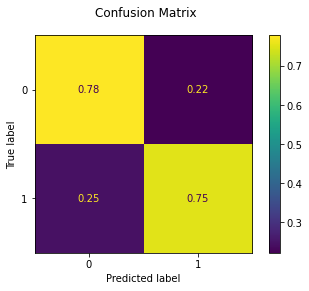

In [63]:
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train, y_train)
y_pred = model_lr.predict(X_test)
print('accuracy_score:', accuracy_score(y_test, y_pred))
disp = plot_confusion_matrix(model_lr, X_test, y_test, normalize='true')
disp.figure_.suptitle("Confusion Matrix")
plt.show()

accuracy_score: 0.76835


C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


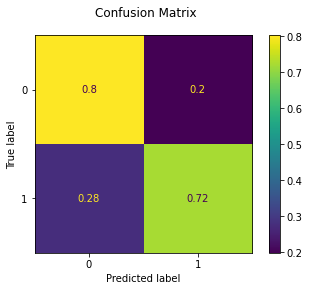

In [64]:
model_kn = KNeighborsClassifier(n_neighbors=50, algorithm='brute')
model_kn.fit(X_train, y_train)
y_pred = model_kn.predict(X_test)
print('accuracy_score:', accuracy_score(y_test, y_pred))
disp = plot_confusion_matrix(model_kn, X_test, y_test, normalize='true')
disp.figure_.suptitle("Confusion Matrix")
plt.show()

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [65]:
## your code
from sklearn.model_selection import GridSearchCV
# Сетка параметров 
C = [0.01, 0.05, 0.08, 0.1, 1, 10]
penalty = ['l2', 'l1', 'elasticnet']
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
class_weight = ['none', 'balanced']

param = dict(penalty=penalty, solver=solver, class_weight=class_weight, C=C)

gridsearch = GridSearchCV(model_lr, param_grid=param, scoring='roc_auc', n_jobs=-1, cv=5)
grid_result = gridsearch.fit(X_train, y_train)

# Печать лучших параметров
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
540 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1528, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1150, in _fit_liblinear
    class_weight_ = compute_class_weight(

Best Score:  0.8273004796591608
Best Params:  {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}


accuracy_score: 0.7666


C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


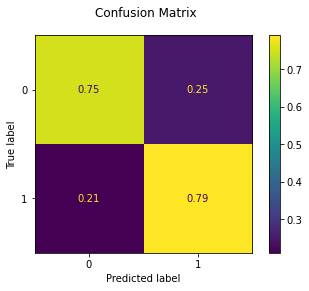

In [66]:
model_lr = LogisticRegression(random_state=42, C=0.01, class_weight='balanced', solver='liblinear')
model_lr.fit(X_train, y_train)
y_pred = model_lr.predict(X_test)
print('accuracy_score:', accuracy_score(y_test, y_pred))
disp = plot_confusion_matrix(model_lr, X_test, y_test, normalize='true')
disp.figure_.suptitle("Confusion Matrix")
plt.show()

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [67]:
test = pd.read_csv('test.csv').set_index('PassengerId')
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 100000 to 199999
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Pclass    100000 non-null  int64  
 1   Name      100000 non-null  object 
 2   Sex       100000 non-null  object 
 3   Age       96513 non-null   float64
 4   SibSp     100000 non-null  int64  
 5   Parch     100000 non-null  int64  
 6   Ticket    94819 non-null   object 
 7   Fare      99867 non-null   float64
 8   Cabin     29169 non-null   object 
 9   Embarked  99723 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 8.4+ MB


In [68]:
# заполним пропуски в признаке стоимости билета медианным значением
test['Fare'] = test['Fare'].fillna(data['Fare'].median())

# заполним пропуски в признаке возраста пассажиров медианными значениями в зависимости от пола и класса
median_f_1 = data['Age'][(data.Sex=='female') & (data.Pclass==1)].median()
median_f_2 = data['Age'][(data.Sex=='female') & (data.Pclass==2)].median()
median_f_3 = data['Age'][(data.Sex=='female') & (data.Pclass==3)].median()
median_m_1 = data['Age'][(data.Sex=='male') & (data.Pclass==1)].median()
median_m_2 = data['Age'][(data.Sex=='male') & (data.Pclass==2)].median()
median_m_3 = data['Age'][(data.Sex=='male') & (data.Pclass==3)].median()

test.loc[(test.Sex=='female') & (test.Pclass==1) & (pd.isna(test.Age)), 'Age'] = median_f_1
test.loc[(test.Sex=='female') & (test.Pclass==2) & (pd.isna(test.Age)), 'Age'] = median_f_2
test.loc[(test.Sex=='female') & (test.Pclass==3) & (pd.isna(test.Age)), 'Age'] = median_f_3
test.loc[(test.Sex=='male') & (test.Pclass==1) & (pd.isna(test.Age)), 'Age'] = median_m_1
test.loc[(test.Sex=='male') & (test.Pclass==2) & (pd.isna(test.Age)), 'Age'] = median_m_2
test.loc[(test.Sex=='male') & (test.Pclass==3) & (pd.isna(test.Age)), 'Age'] = median_m_3

# заполним пропуски в признаке порта посадки модой
test['Embarked'] = test['Embarked'].fillna('S')

In [69]:
# добавим признак наличия каюты
test['Сabin_availability'] = test['Cabin'].isna()
test['Сabin_availability'] = test['Сabin_availability'].replace({False:1, True:0})

In [70]:
# удалим признаки Name, Ticket, Cabin
test.drop(columns = ['Name', 'Ticket', 'Cabin'],axis = 1, inplace=True)

In [71]:
# Преобразуем признак порта посадки в категориальную переменную
test=pd.get_dummies(test, prefix=['Embarked'], columns=['Embarked'])
# Признак пола пассажира преобразуем в числовые переменные, male - 0, female - 1
test['Sex']=test['Sex'].replace({'female':1,'male':0})
test

,Pclass,Sex,Age,SibSp,Parch,Fare,Сabin_availability,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
100000,3,0,19.0,0,0,63.01,0,0,0,1
100001,3,1,53.0,0,0,5.81,0,0,0,1
100002,1,1,19.0,0,0,38.91,1,1,0,0
100003,2,0,25.0,0,0,12.93,0,0,0,1
100004,1,1,17.0,0,2,26.89,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...
199995,3,1,27.0,0,0,10.12,0,0,1,0
199996,1,0,59.0,1,0,68.31,0,0,0,1
199997,3,0,47.0,0,0,10.87,0,0,0,1


In [72]:
test_scaler = scaler.transform(test)
test_scaler

array([[ 1.06609193, -0.88435653, -1.07011921, ..., -0.53397781,
        -0.23948007,  0.61759643],
       [ 1.06609193,  1.13076567,  0.81289698, ..., -0.53397781,
        -0.23948007,  0.61759643],
       [-1.32133135,  1.13076567, -1.07011921, ...,  1.87273699,
        -0.23948007, -1.61918033],
       ...,
       [ 1.06609193, -0.88435653,  0.48060001, ..., -0.53397781,
        -0.23948007,  0.61759643],
       [-1.32133135,  1.13076567,  0.59136566, ...,  1.87273699,
        -0.23948007, -1.61918033],
       [-1.32133135,  1.13076567,  0.14830303, ...,  1.87273699,
        -0.23948007, -1.61918033]])

In [73]:
Y_pred = model_kn.predict(test_scaler)
Y_pred

array([0, 0, 1, ..., 0, 1, 1], dtype=int64)

In [74]:
submission = pd.read_csv('sample_submission.csv')
submission.Survived = Y_pred
submission

,PassengerId,Survived
0,100000,0
1,100001,0
2,100002,1
3,100003,0
4,100004,1
...,...,...
99995,199995,1
99996,199996,0
99997,199997,0
99998,199998,1


In [75]:
submission.to_csv('submission.csv', index=False)

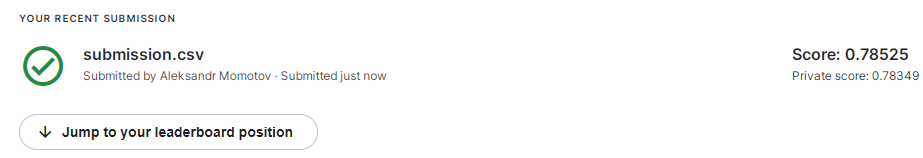